# Predicting Risk with Age
- Nicolas Perez
- Ana Kannan
- Brian Lee
- Conor McCormack
- Kim Nguyen

In [38]:
# importing libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.naive_bayes import ComplementNB, MultinomialNB
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Preparing the data

In [40]:
# function to clean data
def clean(data):
    # dropping less important columns
    data.drop(['Family_Hist_5', 'Medical_History_10', 'Medical_History_24'], axis=1, inplace=True)

    # inputting values based on distribution
    data['Family_Hist_2'].fillna(data['Family_Hist_2'].mean(), inplace=True)
    data['Family_Hist_3'].fillna(data['Family_Hist_3'].mean(), inplace=True)
    data['Family_Hist_4'].fillna(data['Family_Hist_4'].mean(), inplace=True)
    data['Employment_Info_1'].fillna(data['Employment_Info_1'].median(), inplace=True)
    data['Employment_Info_4'].fillna(data['Employment_Info_4'].median(), inplace=True)
    data['Insurance_History_5'].fillna(data['Insurance_History_5'].median(), inplace=True)
    data['Medical_History_1'].fillna(data['Medical_History_1'].median(), inplace=True)
    data['Medical_History_32'].fillna(data['Medical_History_32'].median(), inplace=True)
    data['Employment_Info_6'].fillna(data['Employment_Info_6'].mode()[0], inplace=True)
    data['Medical_History_15'].fillna(data['Medical_History_15'].mode()[0], inplace=True)

    return data

In [41]:
# Splitting data
def split(original):
    original_x = original.drop('Response', axis=1)
    original_y = original['Response']
    young_x = original[original['Ins_Age'] < 0.2].drop('Response', axis=1)
    young_y = original[original['Ins_Age'] < 0.2]['Response']
    old_x = original[original['Ins_Age'] >= 0.2].drop('Response', axis=1)
    old_y = original[original['Ins_Age'] >= 0.2]['Response']

    return original_x, original_y, young_x, young_y, old_x, old_y

Here we input values for missing data and split the dataset into young and old categories. This way, we can run models separately on each group and then join predictions. As a note, we wanted to split the data at the 25 yeear old cutoff, but since variables are anonimized, we decided to go with 0.2

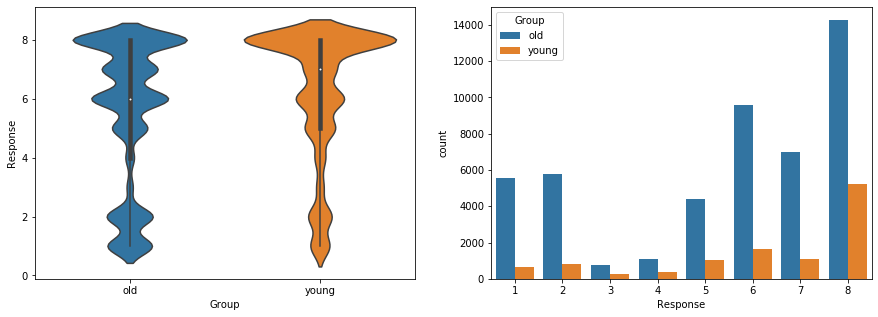

In [42]:
train = pd.read_csv('../data/prudential-life-insurance-assessment/train.csv')
# Clean data
train = clean(train)

# Split into different age groups
train_original_x, train_original_y, train_young_x, train_young_y, train_old_x, train_old_y = split(train)

# Visualizing split
# Create young and old categories
train['Group'] = ['young' if i else 'old' for i in train['Ins_Age'] < .2]

# Visualize distributions
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

a = sns.catplot(x='Group', y='Response', data=train, kind='violin', ax=axes[0])
b = sns.catplot(hue='Group', x='Response', data=train, kind='count', ax=axes[1])
plt.close(3)
plt.close(2)
plt.show()


## Feature Selection
Next, we need to select features based on each age group. Here we select features for the original dataset, and for the young and old age groups

In [43]:
# Get feature ranking
def get_ranking(data, response):
    # Drop categorical data
    data.drop('Product_Info_2', axis=1, inplace=True)

    lr = LinearRegression(normalize=True)
    lr.fit(data.values, response)
    rfe = RFE(lr, n_features_to_select=10)
    rfe.fit(data.values, response)

    labels = list(data.columns)
    ranking = {labels[i]: rfe.ranking_[i] for i in range(len(labels))}
    ranking_list = [(k, ranking[k]) for k in sorted(ranking, key=ranking.get)]
    return ranking_list

In [44]:
# Get feature selection for each group
original_features = [i[0] for i in get_ranking(train_original_x, train_original_y)[:10]]
young_features = [i[0] for i in get_ranking(train_young_x, train_young_y)[:10]]
old_features = [i[0] for i in get_ranking(train_old_x, train_old_y)[:10]]

print("Original dataset features: ")
for i in range(len(original_features)):
    print(i+1, original_features[i])
print("\nOld age group features: ")
for i in range(len(old_features)):
    print(i+1, old_features[i])
print("\nYoung age group features: ")
for i in range(len(young_features)):
    print(i+1, young_features[i])

Original dataset features: 
1 Ins_Age
2 Wt
3 BMI
4 InsuredInfo_2
5 Family_Hist_4
6 Medical_History_5
7 Medical_History_20
8 Medical_History_35
9 Medical_Keyword_3
10 Medical_Keyword_38

Old age group features: 
1 Ins_Age
2 Ht
3 Wt
4 BMI
5 InsuredInfo_2
6 Family_Hist_4
7 Medical_History_5
8 Medical_History_20
9 Medical_Keyword_3
10 Medical_Keyword_38

Young age group features: 
1 Ins_Age
2 Wt
3 BMI
4 InsuredInfo_2
5 Medical_History_5
6 Medical_History_20
7 Medical_History_30
8 Medical_History_38
9 Medical_Keyword_3
10 Medical_Keyword_41


## Running Models and comparing results

In [45]:
# Random Forests
def random_forests(x, y):
    # Split into train and test
#     X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=66)
    # fitting model
    rfc = RandomForestClassifier()
    rfc.fit(x, y)
    rfc_predict = rfc.predict(x)

    return rfc_predict

In [46]:
# Naive Bayes
def naive_bayes(x, y):
    # import complementNB,MultinomialNB
    cpl = ComplementNB()
    mnb = MultinomialNB()
    # train our dataset
    cpl.fit(x, y)
    mnb.fit(x, y)
    # perform prediction and find accuracy
    y_test_cpl = cpl.predict(x)
    y_test_mnb = mnb.predict(x)

    return y_test_cpl, y_test_mnb

In [47]:
# Run Models
# Random Forests:
print("Running Random Forests: ")
original_rfe = random_forests(train_original_x[original_features], train_original_y)
young_old_rfe = np.concatenate((random_forests(train_old_x[old_features], train_old_y),
                          random_forests(train_young_x[young_features], train_young_y)))
print("Accuracy using one model: ", accuracy_score(original_rfe, train_original_y))
print("Accuracy using two models: ",
accuracy_score(young_old_rfe, np.concatenate((train_old_y.values, train_young_y.values))))

print("============================")

# Naive Bayes
print("Running Naive Bayes: ")
original_cpl, original_mnb = naive_bayes(train_original_x[original_features], train_original_y)
old_cpl, old_mnb = naive_bayes(train_old_x[old_features], train_old_y)
young_cpl, young_mnb = naive_bayes(train_young_x[young_features], train_young_y)
young_old_mnb = np.concatenate((old_mnb, young_mnb))
young_old_cpl = np.concatenate((old_cpl, young_cpl))
print("Multinomial Naive Bayes Accuracy with 1 model: ", accuracy_score(original_mnb, train_original_y))
print("Multinomial Naive Bayes Accuracy with 2 models: ",
      accuracy_score(young_old_mnb, np.concatenate((train_old_y.values, train_young_y.values))))
print("Complement Naive Bayes Accuracy with 1 model: ", accuracy_score(original_cpl, train_original_y))
print("Complement Naive Bayes Accuracy with 2 models: ",
      accuracy_score(young_old_cpl, np.concatenate((train_old_y.values, train_young_y.values))))

Running Random Forests: 
Accuracy using one model:  0.9167073643084488
Accuracy using two models:  0.8848621612973847
Running Naive Bayes: 
Multinomial Naive Bayes Accuracy with 1 model:  0.34901736245600445
Multinomial Naive Bayes Accuracy with 2 models:  0.34926996850844544
Complement Naive Bayes Accuracy with 1 model:  0.36184974992000807
Complement Naive Bayes Accuracy with 2 models:  0.3597446994829996


## Findings and Next Steps
- Feature space wasn't too different between groups. Could use SVD or PCA and check results
- Random forests and naive bayes were used in their "out of the box" form, it is important to do hyper-parameter tuning to see how results differ.
- Do Cross Validation to see if the Random Forest Model overfit.